# Basic Pre Processing
making the data cooler

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [2]:
def pre_process(path: str) -> list:
    data_v0 = pd.read_csv(path)
    record = {}
    for car in data_v0["vehicle_no"].unique():
        record[car] = [None, None]
    
    for idx, row in data_v0.iterrows():
        car = row["vehicle_no"]
        cam = row["camera_id"]
        t = row["timestamp"]
        
        if cam == 1:
            record[car][0] = t
        elif cam == 2:
            record[car][1] = t
        else:
            raise ValueError("BAD CAM")
    
    data_v1 = []
    for key, val in record.items():
        data_v1.append([key, *val])
    
    return data_v1

ParkingData = pre_process("./air-trafic-prediction/parkingLot (1).csv")

In [3]:
def get_date(t) -> str:
    return (datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S") - datetime.timedelta(minutes=1)).strftime("%Y-%m-%d")

In [4]:
class ForecastStuff:
    TEST_FRAC = 0.2
    FORECAST_DAYS = 7
    
    def __init__(self, data: np.ndarray, title: str):
        self.data = data
        self.title = title
        self.params = None
        self.Y_LABEL = None
        
    
    def display(self, **date_freqs: np.ndarray) -> None:
        plt.figure(figsize=(14, 7))
        for name, date_freq in date_freqs.items():
            plt.plot(date_freq[0], date_freq[1], label=name.replace('_', ' '))
        plt.title(self.title)
        plt.xlabel('Date')
        plt.ylabel(self.Y_LABEL)
        plt.legend()
        plt.show()
    
    def fit(self):
        cutoff = int(self.data.shape[1] * (1 - self.TEST_FRAC))

        train = self.data[:, :cutoff]
        test = self.data[:, cutoff:]
        
        model = ARIMA(list(train[1, :]), **self.params)
        model_fit = model.fit()
        
        predicted = model_fit.forecast(steps=test.shape[1])
        predicted_stuff = test.copy()
        predicted_stuff[1, :] = predicted
        
        self.display(training_data=train, testing_data=test, predicted_data=predicted_stuff)
        
        mase = mean_absolute_scaled_error(test[1, :], predicted, y_train=test[1, :])
        print(f"Mean Absolute Scaled Error (MASE): {mase}")
        
        mape = np.mean(np.abs((test[1, :] - predicted) / test[1, :])) * 100
        print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
    
    def forecast(self) -> None:
        model_fore = ARIMA(list(self.data[1, :]), **self.params)
        model_fore_fit = model_fore.fit()
        predicted = model_fore_fit.forecast(steps=self.FORECAST_DAYS)
        last_date = self.data[0, -1]
        predicted_dates = [last_date + datetime.timedelta(days=i) for i in range(1, self.FORECAST_DAYS + 1)]
        predicted_stuff = np.array([predicted_dates, predicted])
        
        
        self.display(previous_data=self.data, predicted_data=predicted_stuff)

# Q1 A
Forecasting total number of vehicles entering parking per day

In [5]:
def get_date_freq(data: list) -> np.ndarray:
    date_freq_d = {}
    for row in data:
        # As long as either entry or exit time is there, it will register (solving the 20minute gap problems)
        
        if row[1]:
            date = get_date(row[1])
        else:
            date = get_date(row[2])
        
        if date not in date_freq_d:
            date_freq_d[date] = 1
        else:
            date_freq_d[date] += 1
    
    date_freq_l = [[], []]
    for key, val in sorted(date_freq_d.items()):
        date_freq_l[0].append(datetime.datetime.strptime(key, "%Y-%m-%d"))
        date_freq_l[1].append(val)
    
    return np.array(date_freq_l)

In [6]:
class ForecastCarNumber(ForecastStuff):
    def __init__(self, data: np.ndarray, title: str = "Car Number"):
        super().__init__(data, title)
        self.params = dict(order=(3, 1, 1), seasonal_order=(2, 1, 0, 7), enforce_stationarity=False, enforce_invertibility=False)
        self.Y_LABEL = "Number of Cars"

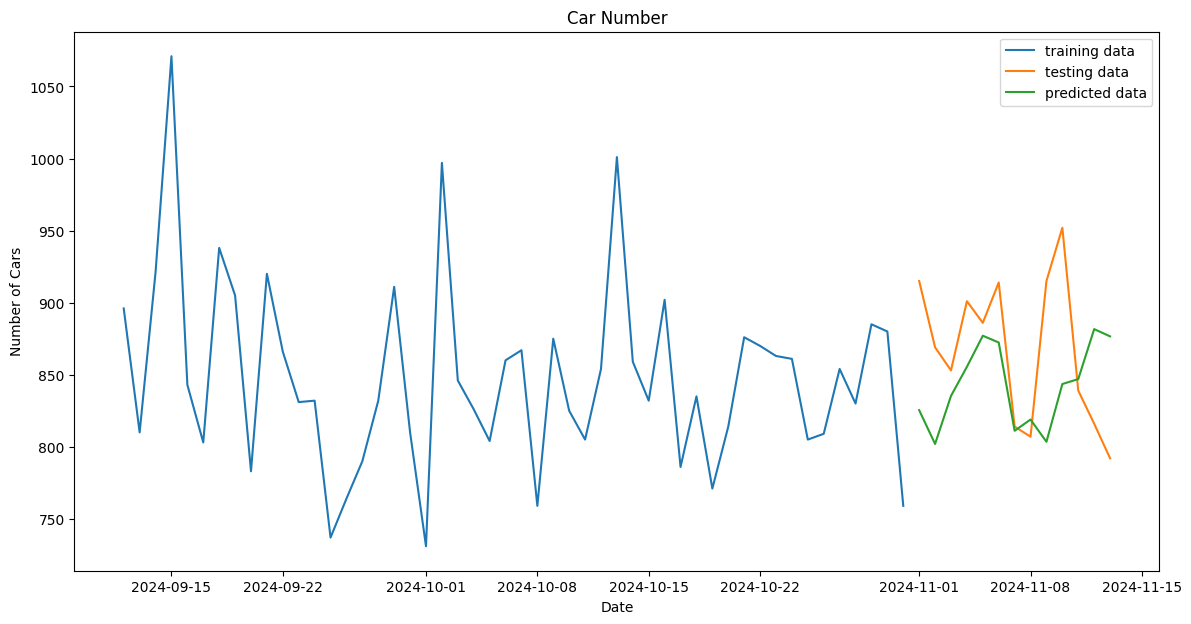

Mean Absolute Scaled Error (MASE): 1.0839801267465763
Mean Absolute Percentage Error (MAPE): 5.79176713346307%


In [7]:
forecast_car_number = ForecastCarNumber(get_date_freq(ParkingData))
forecast_car_number.fit()

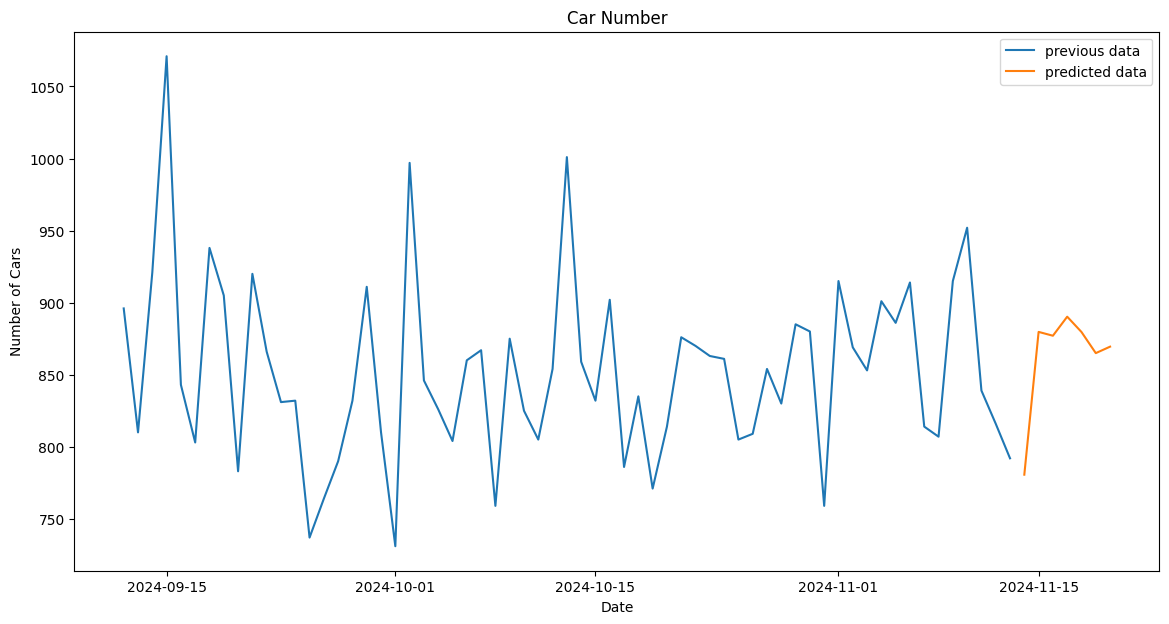

In [8]:
forecast_car_number.forecast()

# Q1 B
Forecasting average parking time per day

In [9]:
def get_park_time(data: list) -> np.ndarray:
    park_time_d = {}
    for row in data:
        if row[1] and row[2]:
            date = get_date(row[1])
            
            if date not in park_time_d:
                park_time_d[date] = []
            
            park_time_d[date].append(datetime.datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S") - datetime.datetime.strptime(row[1], "%Y-%m-%d %H:%M:%S"))
    
    park_time_l = [[], []]
    for key, val in sorted(park_time_d.items()):
        park_time_l[0].append(datetime.datetime.strptime(key, "%Y-%m-%d"))
        some = val[0]
        for i in val[1:]:
            some += i
        avg_time = some / len(val)
        avg_minutes = avg_time.seconds / 60
        park_time_l[1].append(avg_minutes)
    
    return np.array(park_time_l)

In [10]:
class ForecastParkTime(ForecastStuff):
    def __init__(self, data: np.ndarray, title: str ="Park time"):
        super().__init__(data, title)
        self.params = dict(order=(2, 1, 1), seasonal_order=(2, 0, 1, 7), enforce_stationarity=False, enforce_invertibility=False)
        self.Y_LABEL = "Average Park Time (Minutes)"

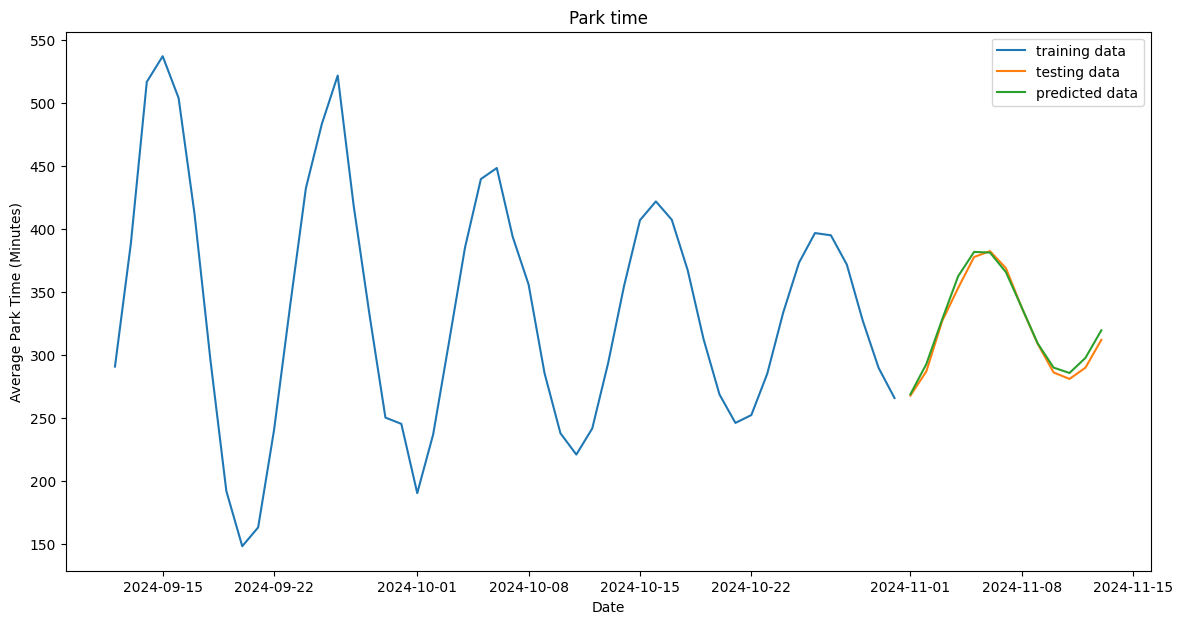

Mean Absolute Scaled Error (MASE): 0.18803076826747417
Mean Absolute Percentage Error (MAPE): 1.2320335545517405%


In [11]:
forecast_park_time = ForecastParkTime(get_park_time(ParkingData))
forecast_park_time.fit()

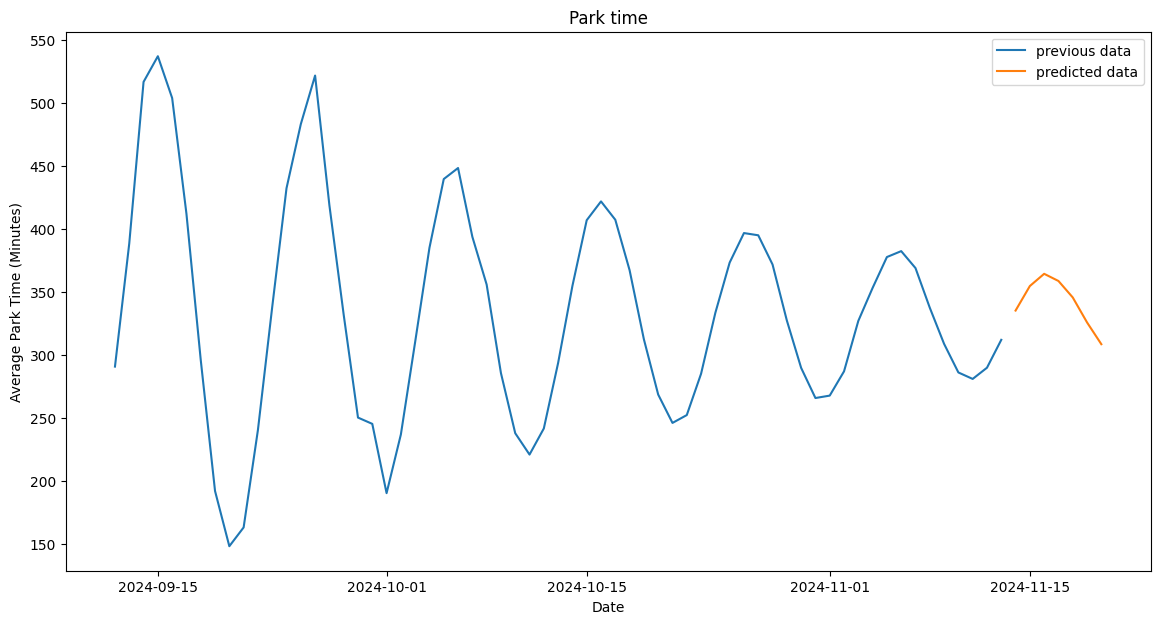

In [12]:
forecast_park_time.forecast()

# Q1 C
Outlier smoothing and Missing value imputation

In [13]:
class AdvancedForecastCarNumber(ForecastCarNumber):
    def __init__(self, data: np.ndarray, title: str, display_data: np.ndarray):
        super().__init__(data, title)
        self.display_data = display_data
    
    def display(self, **date_freqs: np.ndarray) -> None:
        plt.figure(figsize=(14, 7))
        plt.plot(self.display_data[0], self.display_data[1], label="actual data")
        for name, date_freq in date_freqs.items():
            plt.plot(date_freq[0], date_freq[1], label=name.replace('_', ' '))
        plt.title(self.title)
        plt.xlabel('Date')
        plt.ylabel(self.Y_LABEL)
        plt.legend()
        plt.show()

In [14]:
class AdvancedForecastParkTime(ForecastParkTime):
    def __init__(self, data: np.ndarray, title: str, display_data: np.ndarray):
        super().__init__(data, title)
        self.display_data = display_data
    
    def display(self, **date_freqs: np.ndarray) -> None:
        plt.figure(figsize=(14, 7))
        plt.plot(self.display_data[0], self.display_data[1], label="actual data")
        for name, date_freq in date_freqs.items():
            plt.plot(date_freq[0], date_freq[1], label=name.replace('_', ' '))
        plt.title(self.title)
        plt.xlabel('Date')
        plt.ylabel(self.Y_LABEL)
        plt.legend()
        plt.show()

## Simple Exponential Smoothing

In [15]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [16]:
def simple_exponential(data: np.ndarray) -> np.ndarray:
    model = SimpleExpSmoothing(data[1, :])
    model_fit = model.fit()
    out = data.copy()
    out[1, :] = model_fit.fittedvalues
    return out

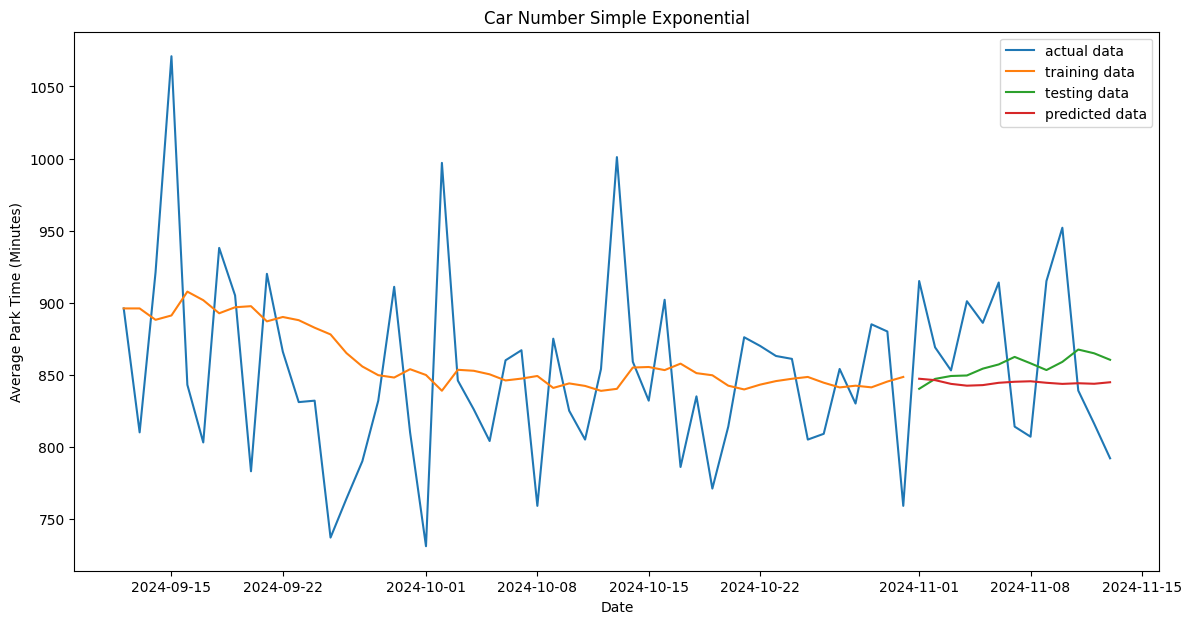

Mean Absolute Scaled Error (MASE): 2.7803961704124123
Mean Absolute Percentage Error (MAPE): 1.419215538998647%


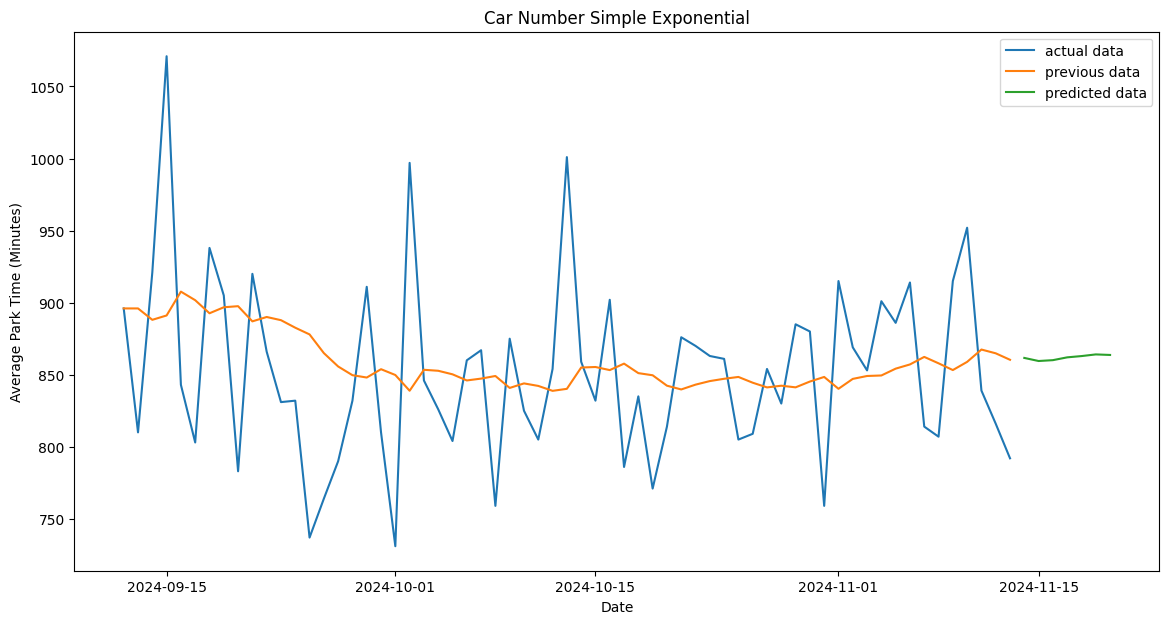

In [17]:
forecast_date_freq = AdvancedForecastParkTime(simple_exponential(get_date_freq(ParkingData)), "Car Number Simple Exponential", get_date_freq(ParkingData))
forecast_date_freq.fit()
forecast_date_freq.forecast()

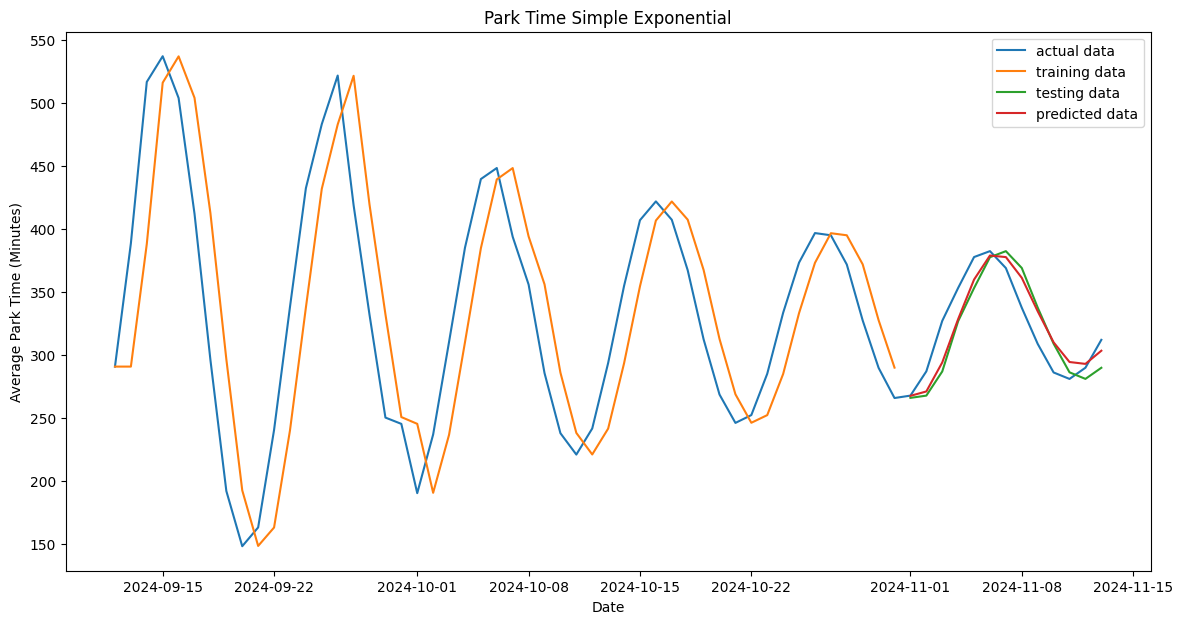

Mean Absolute Scaled Error (MASE): 0.2931476886837957
Mean Absolute Percentage Error (MAPE): 1.8042371493189606%


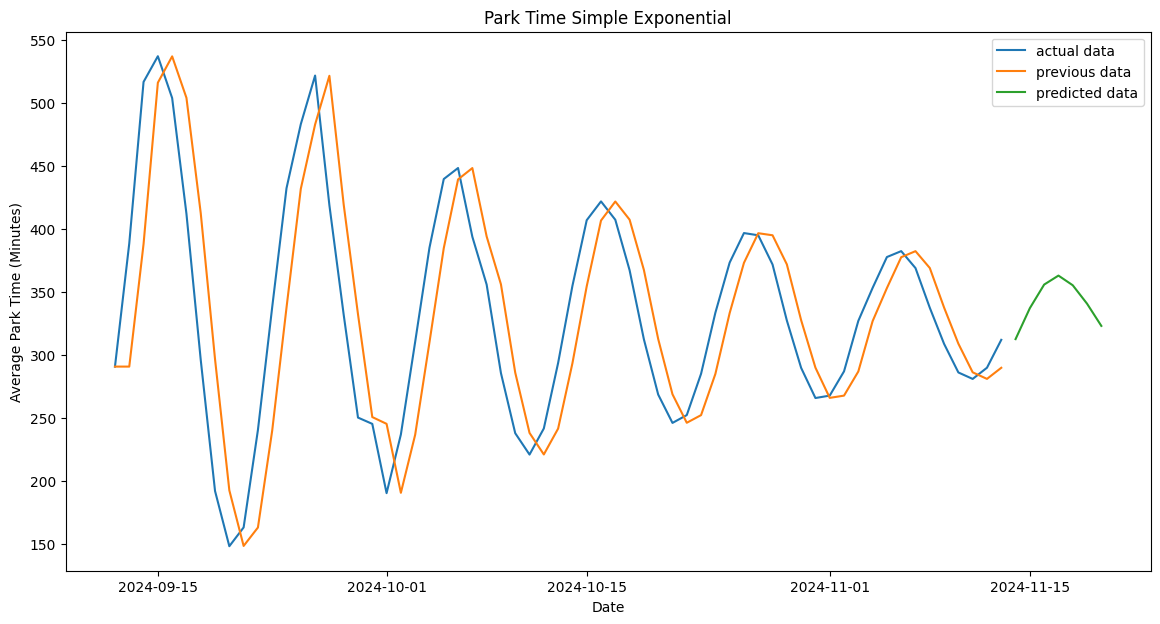

In [18]:
forecast_park_time = AdvancedForecastParkTime(simple_exponential(get_park_time(ParkingData)), "Park Time Simple Exponential", get_park_time(ParkingData))
forecast_park_time.fit()
forecast_park_time.forecast()

## Moving Average

In [19]:
def moving_average(data: np.ndarray) -> np.ndarray:
    out = data.copy()
    out[1, 0] = 2 / 3 * data[1, 0] + 1 / 3 * data[1, 1]
    for i in range(1, data.shape[1] - 1):
        out[1, i] = sum(data[1, i - 1:i + 2]) / 3
    out[1, data.shape[1] - 1] = 2 / 3 * data[1, data.shape[1] - 1] + 1 / 3 * data[1, data.shape[1] - 2]
    
    return out

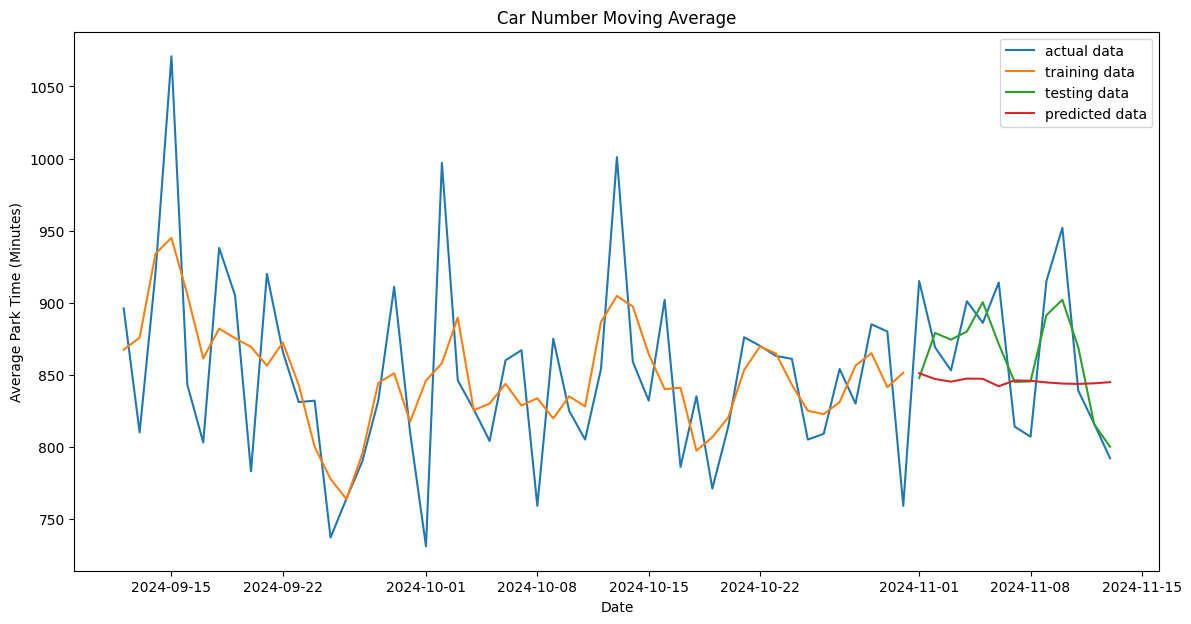

Mean Absolute Scaled Error (MASE): 1.2847911961737513
Mean Absolute Percentage Error (MAPE): 3.4017289526819665%


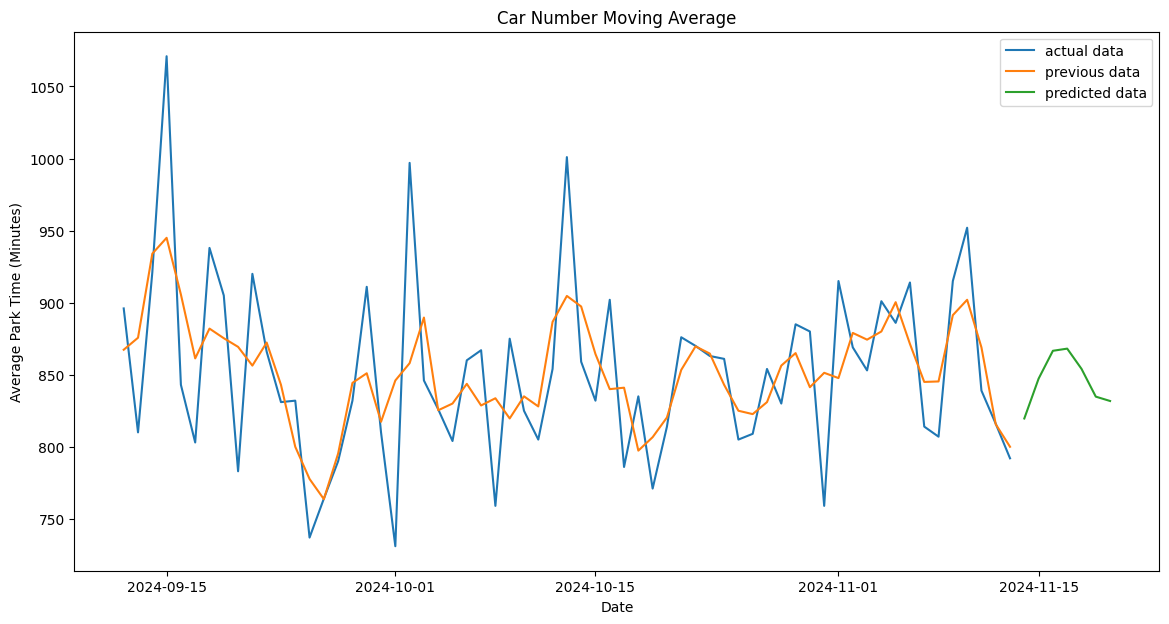

In [20]:
forecast_date_freq = AdvancedForecastParkTime(moving_average(get_date_freq(ParkingData)), "Car Number Moving Average", get_date_freq(ParkingData))
forecast_date_freq.fit()
forecast_date_freq.forecast()

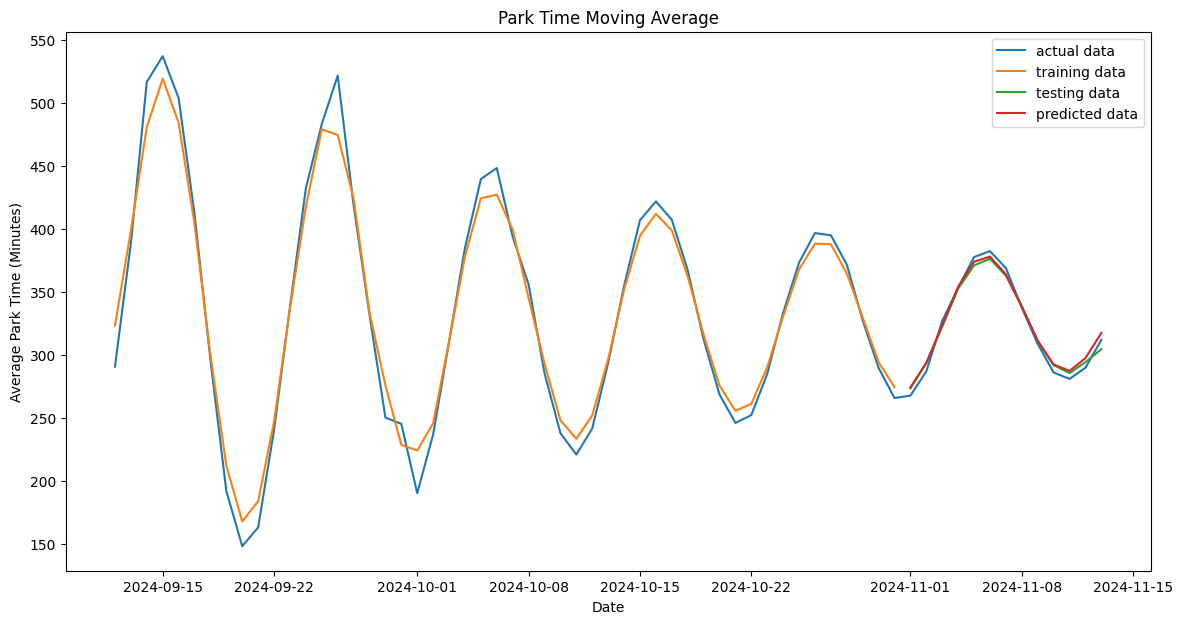

Mean Absolute Scaled Error (MASE): 0.124206323957116
Mean Absolute Percentage Error (MAPE): 0.6979546923028426%


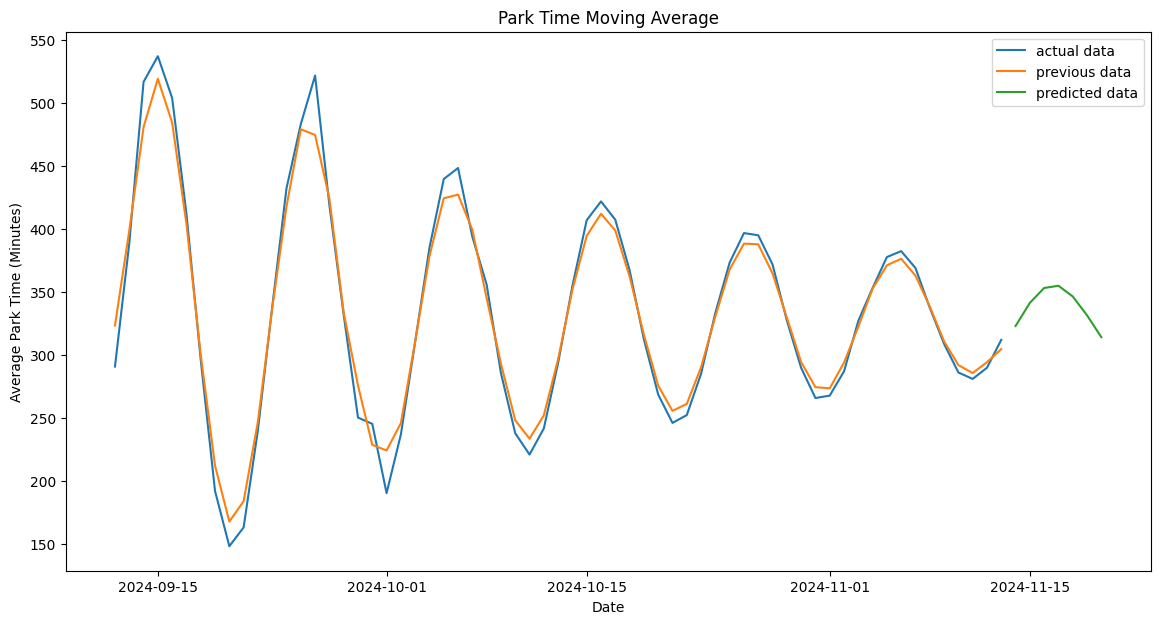

In [21]:
forecast_park_time = AdvancedForecastParkTime(moving_average(get_park_time(ParkingData)), "Park Time Moving Average", get_park_time(ParkingData))
forecast_park_time.fit()
forecast_park_time.forecast()